In [224]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from hera_cal.io import HERAData, HERACal
import uvtools.plot as plotter
from pyuvdata import UVData
import hera_pspec as hp
import copy, os, itertools, inspect
from hera_pspec.data import DATA_PATH
import uvtools.plot as plotter
from hera_cal import delay_filter
import matplotlib
import operator
from scipy import stats

In [2]:
# load data into UVData object
dfile = os.path.join(DATA_PATH, 'zen.2458116.34176.xx.HH.uvOCRS')
uvd = UVData()
uvd.read(dfile)

# Load data into HERAData object
hd = HERAData('zen.2458116.34176.xx.HH.uvOCRS', filetype='miriad')
data, flags, _ = hd.read()

In [3]:
# get baselines and polarization
bls = list(data.keys())

# get autocorrelated baselines
# do not run this cell if [plot delay spectra for all baselines] = True
# bls = []
# for i in range(len(uvd.get_antpairs())):
#     if uvd.get_antpairs()[i][0]==uvd.get_antpairs()[i][1]:
#         bls.append(uvd.get_antpairs()[i])

In [44]:
# choose range of frequencies
freqs = [140, 180] # MHz
idx1 = (np.abs(uvd.freq_array[0] - freqs[0]*1e6)).argmin()
idx2 = (np.abs(uvd.freq_array[0] - freqs[1]*1e6)).argmin()
chan = [idx1, idx2]

# create visibility data dictionary for this frequency range and filter out flagged visbilities
vis = {}
for i in range(len(bls)):
    vis[bls[i]] = data[bls[i]][:,chan[0]:chan[1]] * ~flags[bls[i]][:,chan[0]:chan[1]]

In [47]:
vis = {x:y for x,y in vis.items() if y[0][0]!=0}
bls = list(vis.keys())

In [48]:
# create delay power spectra
dly_spec = {}
for i in range(len(bls)):
    # Fourier-transform along frequency
    vis_dt = np.fft.fftshift(np.fft.fft(vis[bls[i]], axis=1), axes=1)
    
    # average Fourier transformed visibilities along time
    mean_vis_dt = []
    for j in range(np.shape(vis_dt)[1]):
        mean_vis_dt.append(np.abs(np.mean(vis_dt[:,j])))
    
    dly_spec[bls[i]] = np.asarray(mean_vis_dt)

In [49]:
# create delay axis
freq_width =  np.median(np.diff(uvd.freq_array[0][chan[0]:chan[1]])) / 1e9 # GHz
delays = np.fft.fftshift(np.fft.fftfreq(len(uvd.freq_array[0][chan[0]:chan[1]]), freq_width)) # ns
dlys = np.linspace(np.min(delays), np.max(delays), len(dly_spec[bls[0]]))

In [50]:
# The cable reflection occurs between 500 ns and 1700 ns. We can 
# find it by calculating the difference between the mean value 
# (between 1800 ns and 2500 ns) and the maximum value (between 
# 500 ns and 1700 ns). If the difference is greater than 0.5, then
# the probability of having cable reflection signal will be higher.

# get index of delay modes in the delay list
dly_modes = [500, 1700, 1800, 2500] # ns
dly_idx = []
for i in range(len(dly_modes)):
    dly_idx.append((np.abs(delays - dly_modes[i])).argmin())

# get baselines with cable reflection
with_reflection = {}
no_reflection = {}
max_reflection = {}
for i in range(len(bls)):
    # find the maximum values (fft'ed visibility) in the chosen delay mode range
    maximum = np.log10(np.max(dly_spec[bls[i]][dly_idx[0]:dly_idx[1]]))
    # find the mean values (fft'ed visibility) in the chosen delay mode range
    mean = np.max(np.log10(dly_spec[bls[i]][dly_idx[2]:dly_idx[3]]))
    # compare the difference with 0.5
    if (maximum-mean) > 0.5:
        with_reflection[bls[i]] = dly_spec[bls[i]]
        max_reflection[bls[i]] = maximum
    else:
        no_reflection[bls[i]] = dly_spec[bls[i]]

<IPython.core.display.Javascript object>


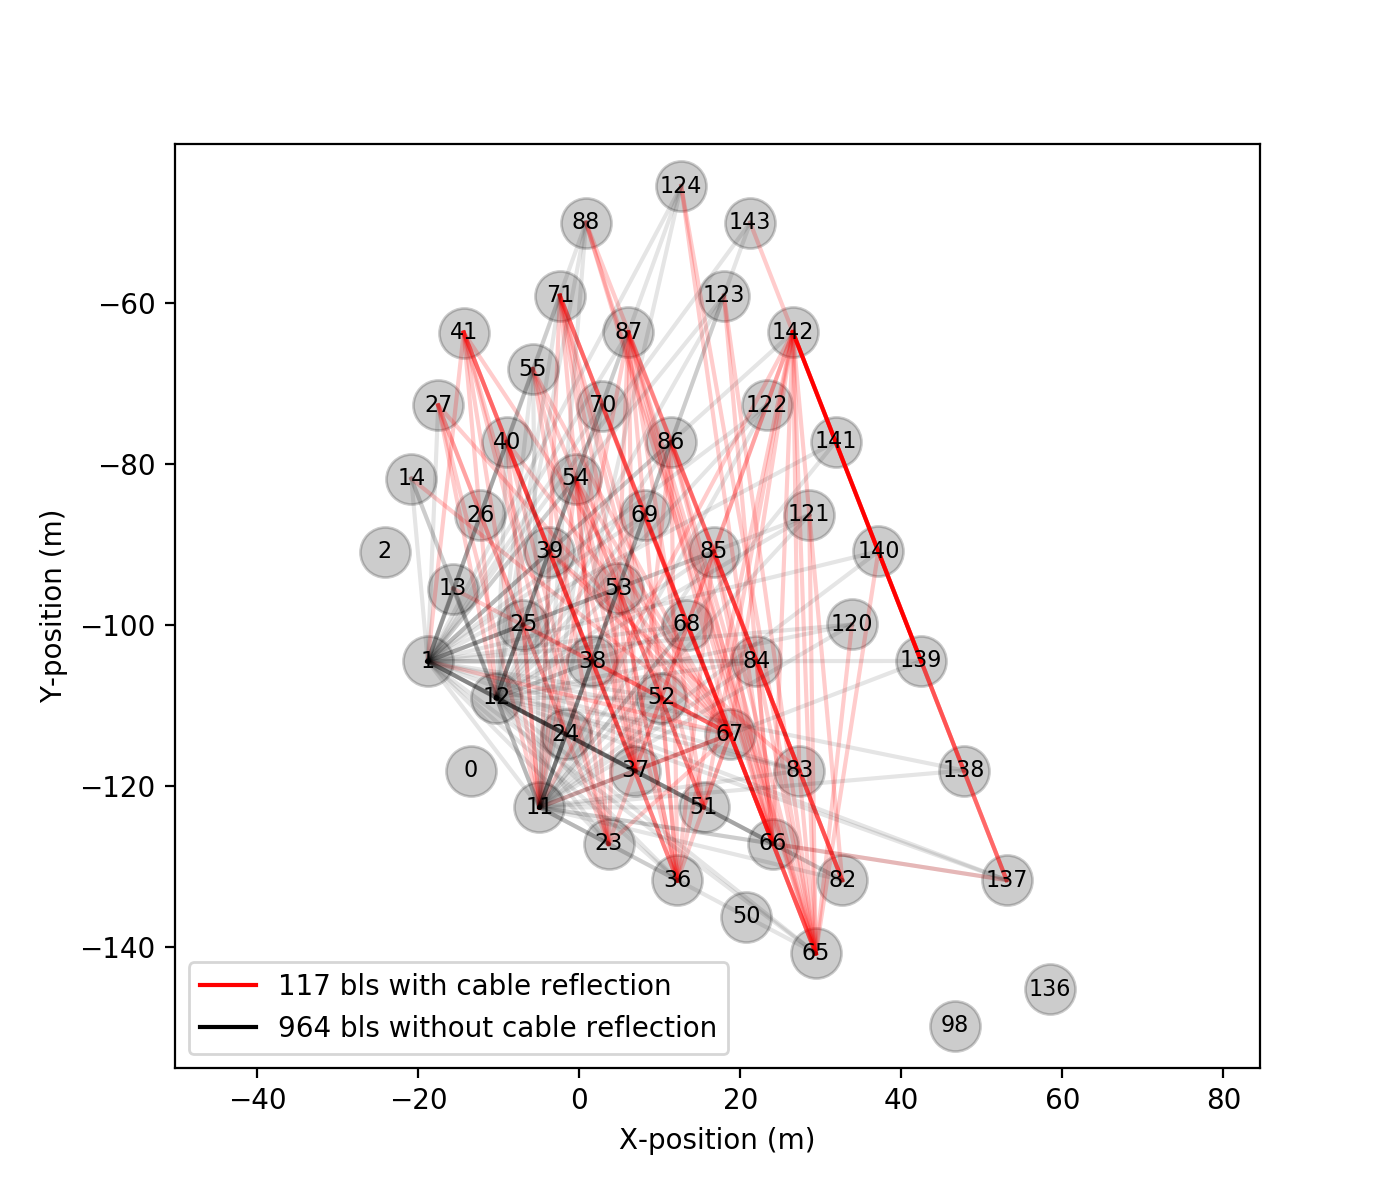

In [51]:
# plot baselines with/without cable reflection

xs = [uvd.antenna_positions[ant][0] for ant in range(len(uvd.antenna_numbers))]
ys = [uvd.antenna_positions[ant][1] for ant in range(len(uvd.antenna_numbers))]

ant_positions = {}
for i in range(len(uvd.antenna_numbers)):
    ant_positions[uvd.antenna_numbers[i]] = uvd.antenna_positions[i]

bls_reflec = list(with_reflection.keys())
x_ant = []
y_ant = []
for i in range(len(bls_reflec)):
    ant = bls_reflec[i]
    x_ant.append([ant_positions[ant[0]][0], ant_positions[ant[1]][0]])
    y_ant.append([ant_positions[ant[0]][1], ant_positions[ant[1]][1]])
    
bls_no_reflec = list(no_reflection.keys())
x_ant_nr = []
y_ant_nr = []
for i in range(len(bls_no_reflec)):
    ant = bls_no_reflec[i]
    x_ant_nr.append([ant_positions[ant[0]][0], ant_positions[ant[1]][0]])
    y_ant_nr.append([ant_positions[ant[0]][1], ant_positions[ant[1]][1]])

plt.figure(figsize=(7, 6))
plt.scatter(xs, ys, marker='.', color='k', s=1300, alpha=0.2) # plot the antenna positions with black circles
for i in range(len(uvd.antenna_numbers)): # loop over antennas
    plt.text(xs[i], ys[i], uvd.antenna_numbers[i], fontsize=8, color='k', va='center', ha='center') # label antenna numbers
for i in range(len(bls_reflec)-1):
    plt.plot(x_ant[i], y_ant[i], 'r-', alpha=0.2)
for i in range(len(bls_reflec)-1):
    plt.plot(x_ant_nr[i], y_ant_nr[i], 'k-', alpha=0.1)
plt.plot(x_ant[-1], y_ant[-1], 'r-', label=str(len(with_reflection))+" bls with cable reflection")
plt.plot(x_ant_nr[-1], y_ant_nr[-1], 'k-', label=str(len(no_reflection))+" bls without cable reflection")
plt.xlabel('X-position (m)')
plt.ylabel('Y-position (m)')
plt.legend(loc='lower left')
plt.axis('equal');

In [53]:
# sort the baselines by maximum intensity of the cable reflection signal
sorted_keys = np.asarray(sorted(max_reflection.items(), key=operator.itemgetter(1)))[:,0]

sorted_with_reflection = []
for i in range(len(sorted_keys)):
    sorted_with_reflection.append(with_reflection[sorted_keys[i]])
sorted_with_reflection = np.asarray(sorted_with_reflection)

<IPython.core.display.Javascript object>


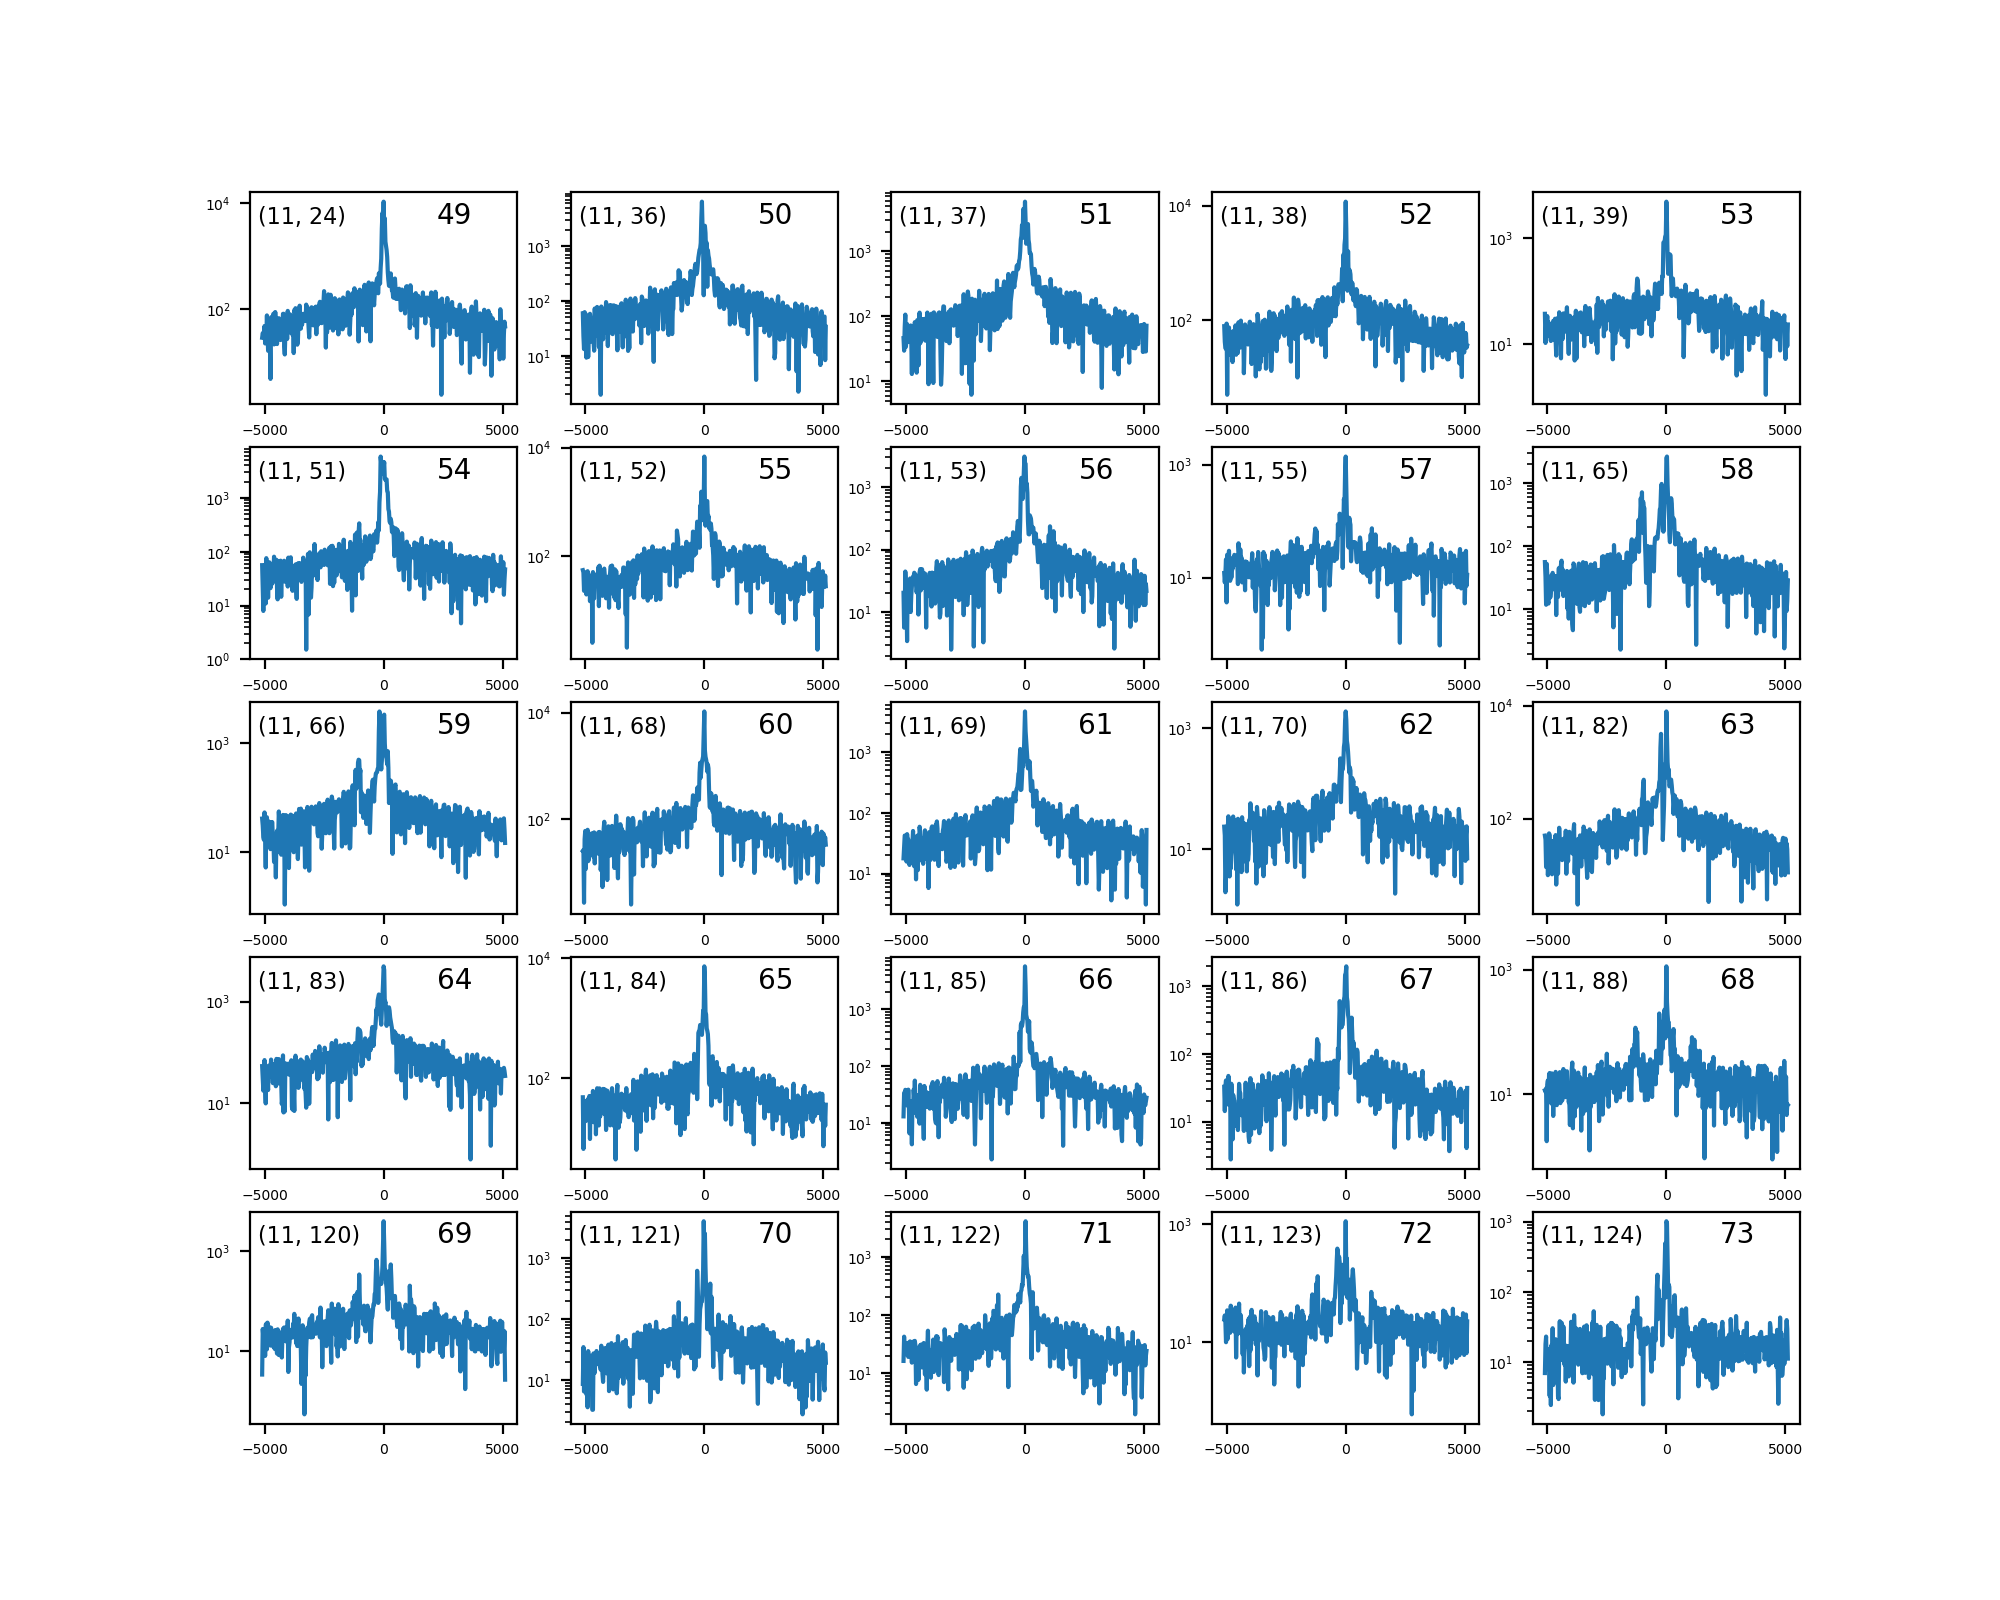

In [93]:
# plot delay spectra without cable reflection (25 spectra each time)

bls_no_reflec = list(no_reflection.keys())
plotting_range = len(bls_no_reflec)-25
plotting_range = 24+25
plt.figure(figsize=(10, 8))
for i in range(1, 26):
    j = i+plotting_range-1
    txt = '('+str(bls_no_reflec[j][0])+', '+str(bls_no_reflec[j][1])+')'
    plt.subplot(5, 5, i)
    plt.semilogy(dlys, no_reflection[bls_no_reflec[j]]) 
    ax = plt.gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(5) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(5) 
    plt.text(0.03, 0.85, txt, fontsize=8, transform=ax.transAxes)
    plt.text(0.7, 0.85, j, transform=ax.transAxes)

<IPython.core.display.Javascript object>


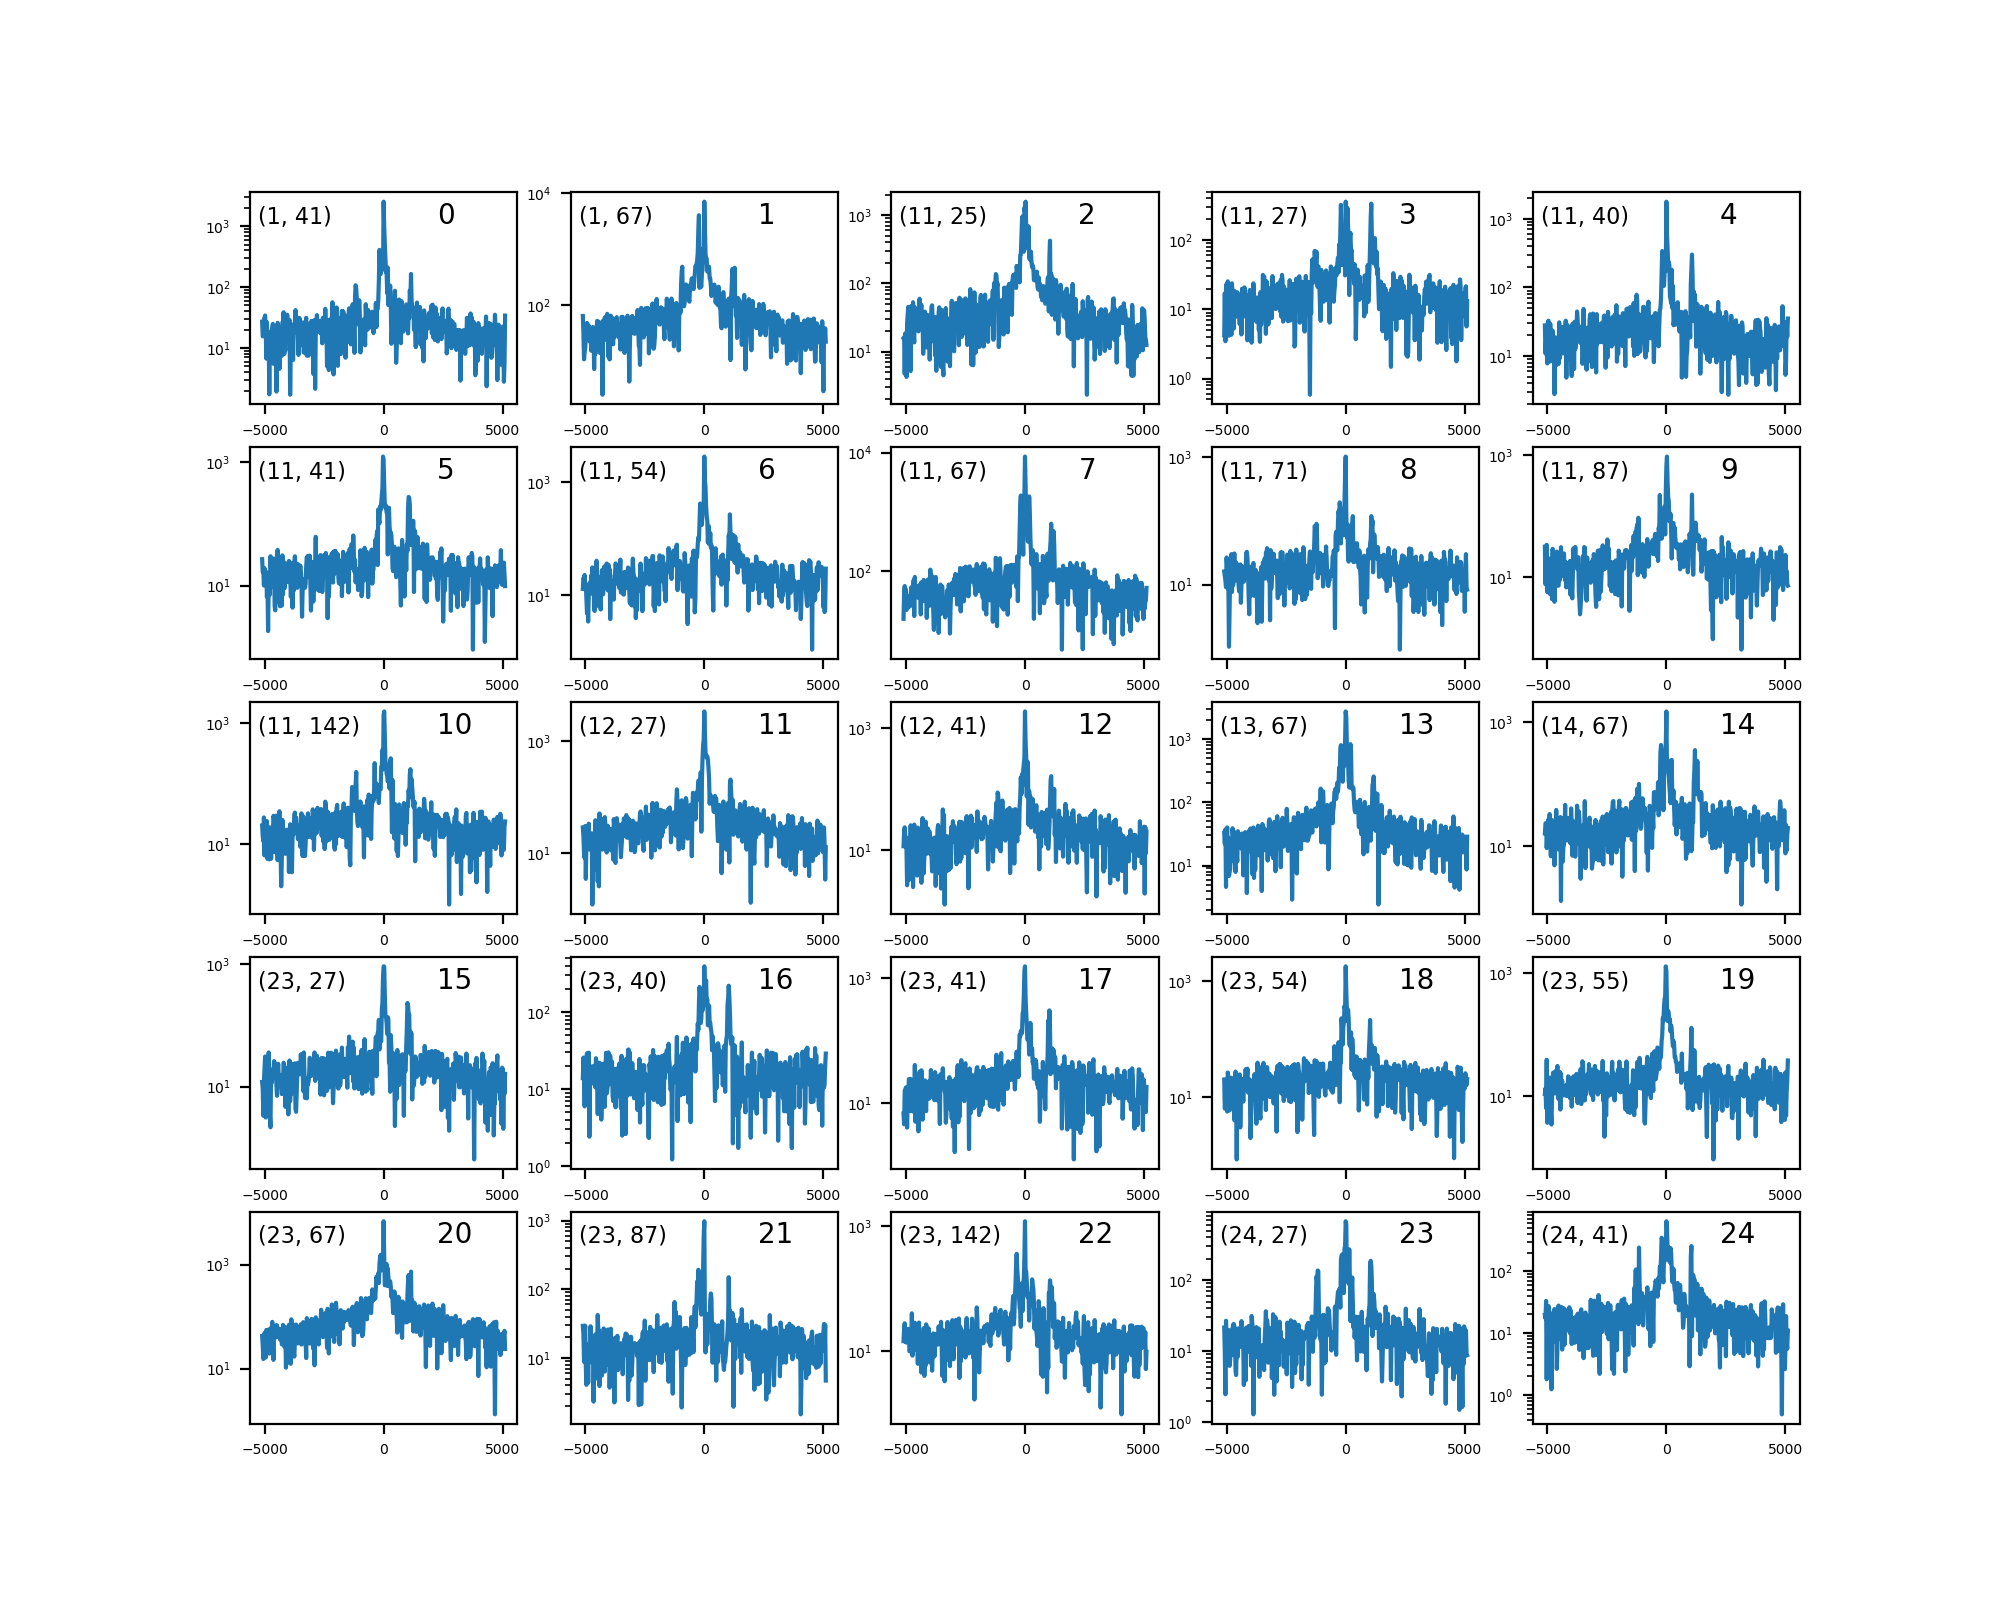

In [91]:
# plot delay spectra with cable reflection (25 spectra each time)

bls_reflec = list(with_reflection.keys())
plotting_range = len(bls_reflec)-25 # 25 bls with the most cable reflection
plotting_range=0
plt.figure(figsize=(10, 8))
for i in range(1, 26):
    j = i+plotting_range-1
    txt = '('+str(bls_reflec[j][0])+', '+str(bls_reflec[j][1])+')'
    plt.subplot(5, 5, i)
    plt.semilogy(dlys, with_reflection[bls_reflec[j]]) 
    ax = plt.gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(5) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(5) 
    plt.text(0.03, 0.85, txt, fontsize=8, transform=ax.transAxes)
    plt.text(0.7, 0.85, j, transform=ax.transAxes)

<IPython.core.display.Javascript object>


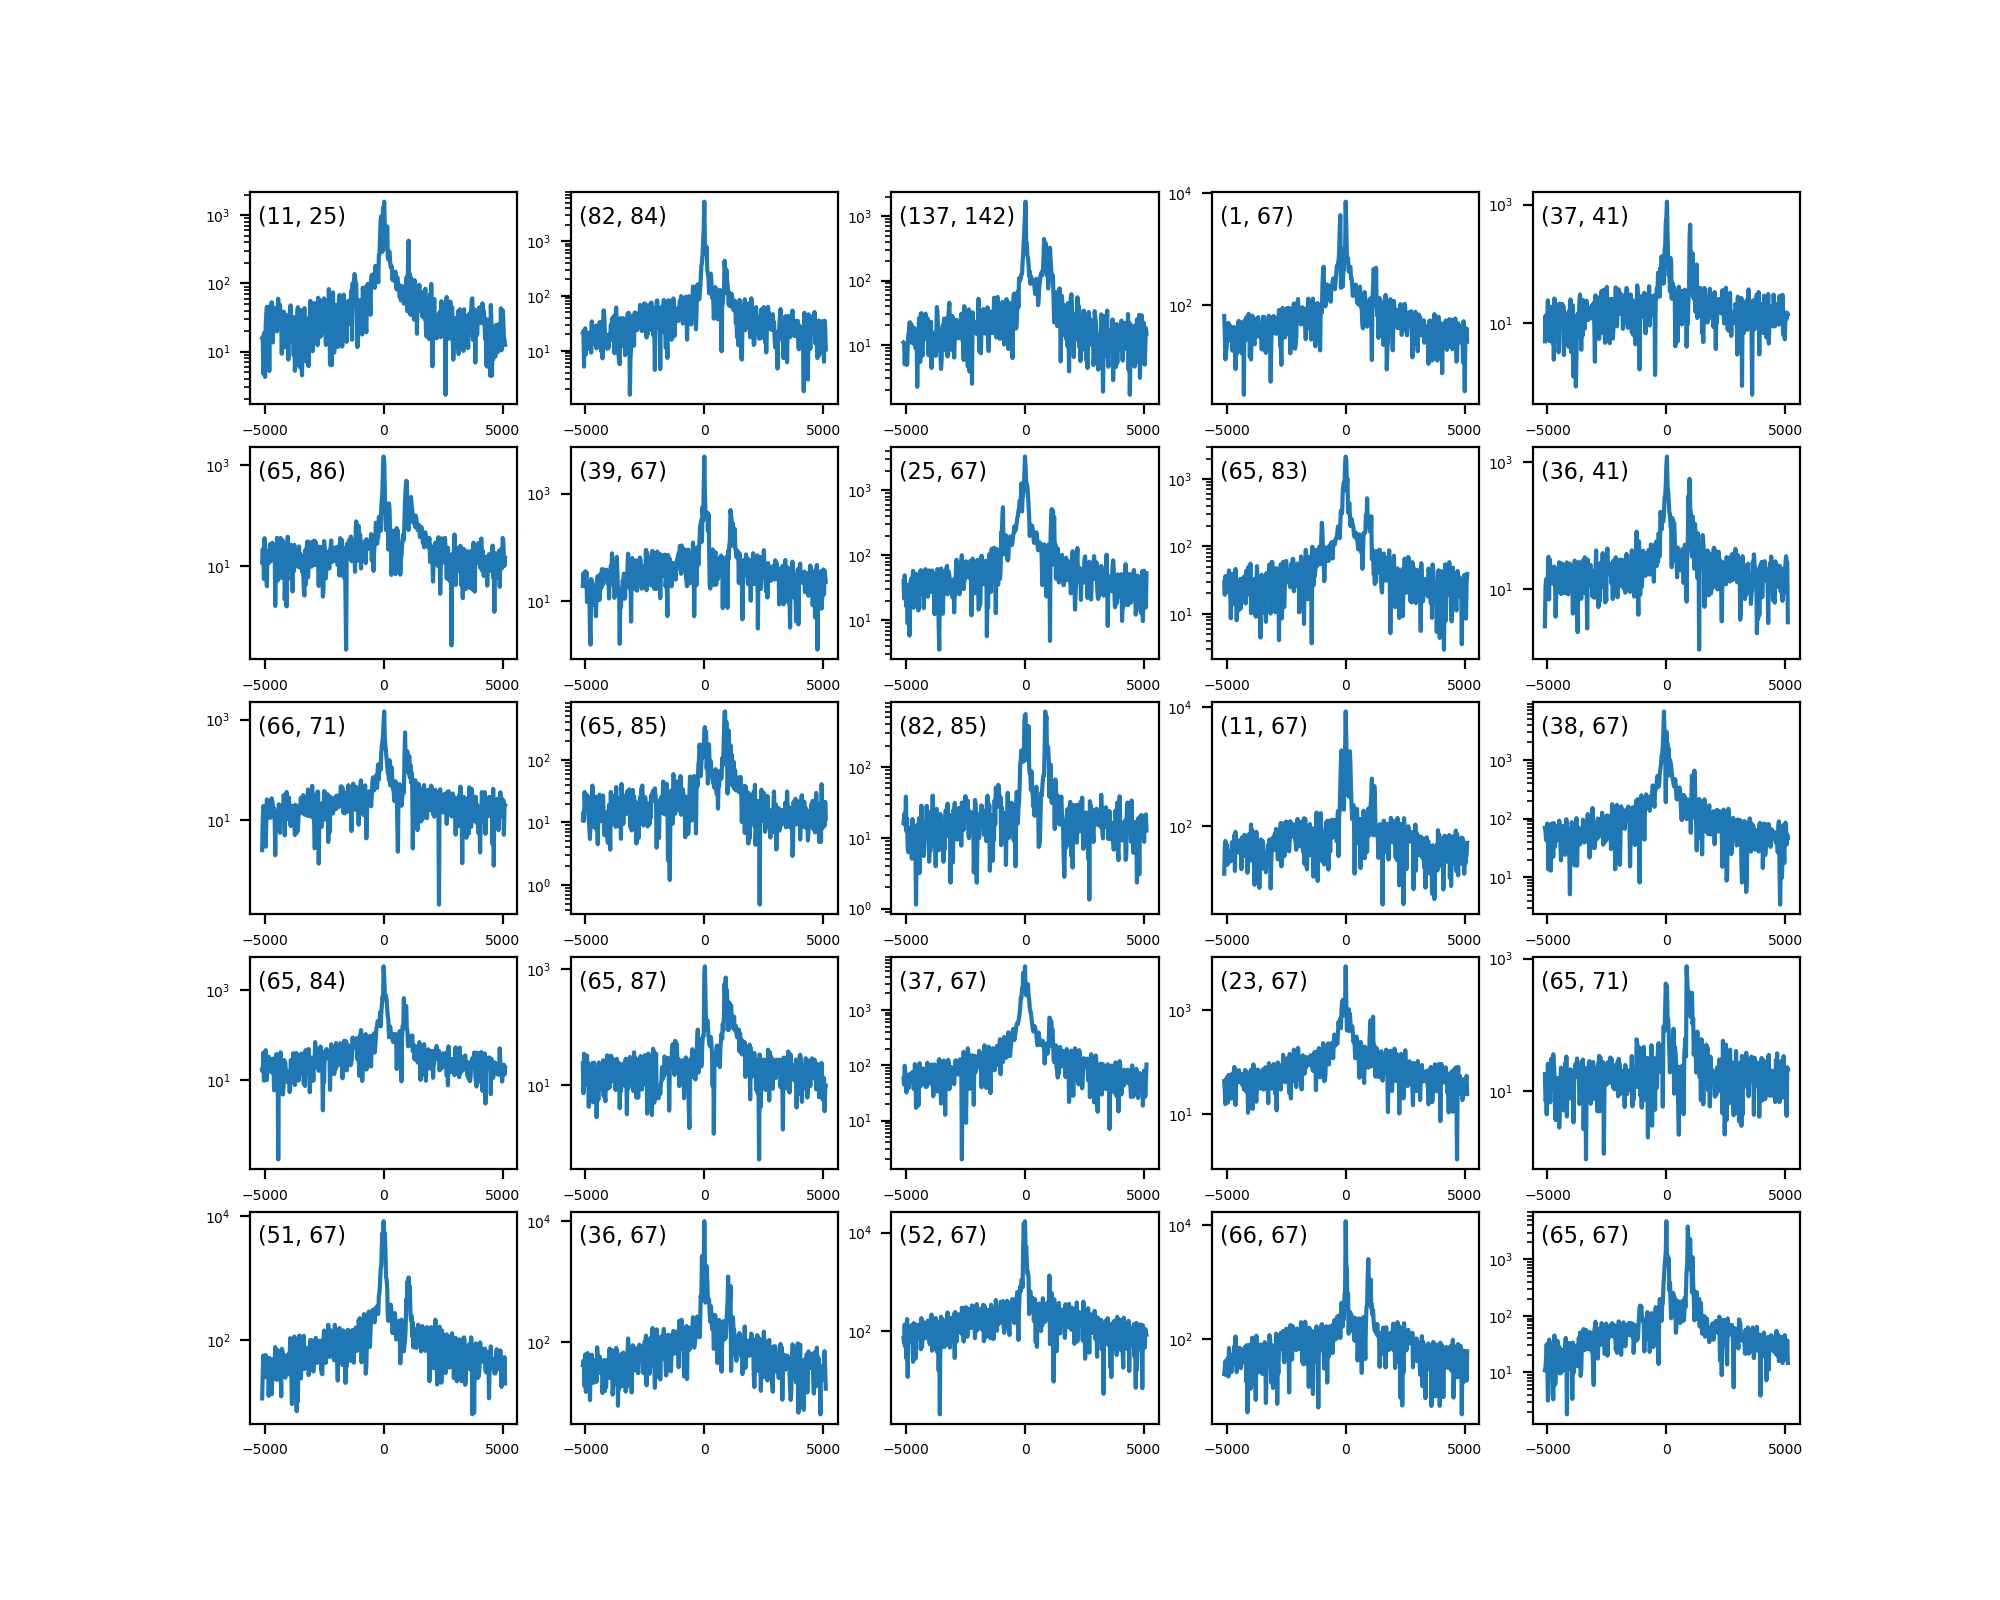

In [238]:
# plot delay spectra with cable reflection (25 spectra each time)

plotting_range = len(sorted_with_reflection)-25 # 25 bls with the most cable reflection

plt.figure(figsize=(10, 8))
for i in range(1, 26):
    j = i+plotting_range-1
    txt = '('+str(sorted_keys[j][0])+', '+str(sorted_keys[j][1])+')'
    plt.subplot(5, 5, i)
    plt.semilogy(dlys, sorted_with_reflection[j]) 
    ax = plt.gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(5) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(5) 
    plt.text(0.03, 0.85, txt, fontsize=8, transform=ax.transAxes)

<IPython.core.display.Javascript object>


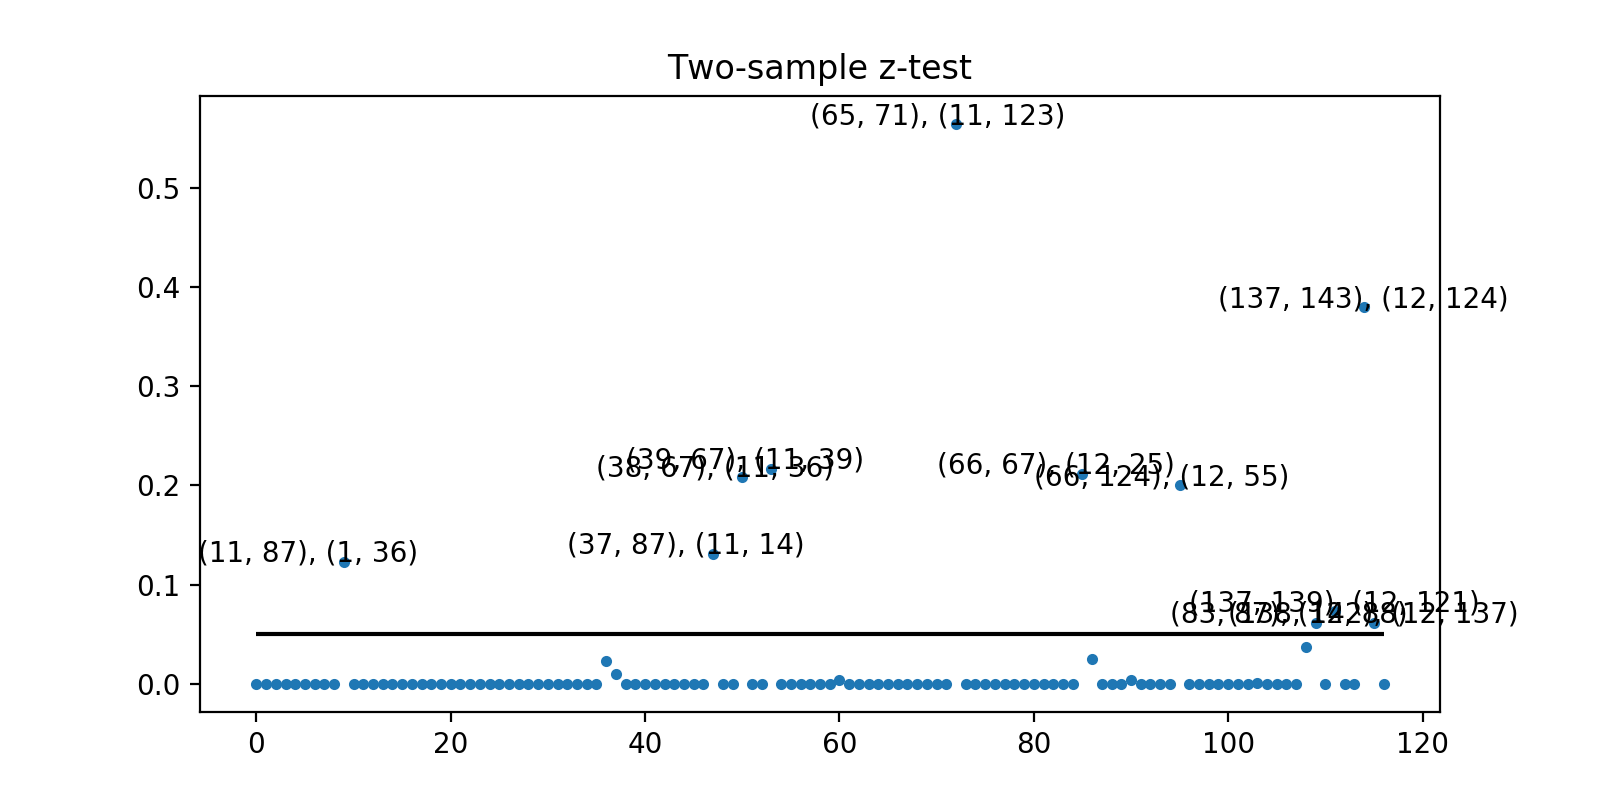

In [248]:
pval = {}
x_dict = {}
dly = [1700, 3500] # ns
dly_idx = []
for i in range(len(dly)):
    dly_idx.append((np.abs(delays - dly[i])).argmin())
    
for i in range(len(with_reflection)):
    pval[list(with_reflection.keys())[i]] = float(stests.ztest(with_reflection[list(with_reflection.keys())[i]][dly_idx[0]:dly_idx[1]], 
                                                           no_reflection[list(no_reflection.keys())[i]][dly_idx[0]:dly_idx[1]], 
                                                           value=0, alternative='two-sided')[1])
    x_dict[list(with_reflection.keys())[i]] = i

z_stats = list(pval.values())
x = list(x_dict.values())

bls_h1 = {}
for i in range(len(x)):
    if z_stats[i] >= 0.05:
        bls_h1[list(with_reflection.keys())[i]] = str(list(with_reflection.keys())[i][:-1])+', '+str(list(no_reflection.keys())[i][:-1])

bls_h1_keys = list(bls_h1.keys())

plt.figure(figsize=(8, 4))
plt.plot(x, z_stats, '.')
plt.hlines(0.05, x[0], x[-1])
plt.title('Two-sample z-test')
for i in range(len(bls_h1)):
    plt.text(x_dict[bls_h1_keys[i]]-15, pval[bls_h1_keys[i]], bls_h1[bls_h1_keys[i]])
plt.show()

# if pval<0.05:
#     print("reject null hypothesis")
# else:
#     print("accept null hypothesis")